In [1]:
import cv2
import numpy as np
import time
import math
import pandas
from datetime import timedelta
import matplotlib.pyplot as plt

fps = np.array([1, 3, 5, 10, 15, 20])
fps2 = np.array([3, 15])
fps3 = np.array([3, 15, 20])

## Node data

### 1 node

In [2]:
''' RGB '''
# rgb unencoded 1024
rgb_bw = np.array([18, 42, 66, 150, 195, 270])
rgb_cpu_os = np.array([4, 6.3, 9.3, 17.8, 26.5, 38])
rgb_cpu_rt = np.array([0.3, 0.4, 0.6, 1.2, 1.8, 2.6])

# rgb encoded 1024
rgbe_bw = np.array([2.3, 5.6, 9.75, 19.3, 24.5, 41.5])
rgbe_cpu_os = np.array([2.5, 3.5, 6.5, 12.5, 14.5, 25.5])
rgbe_cpu_rt = np.array([0.29, 0.4, 0.68, 1.3, 1.9, 2.8])

# rgb unencoded 2048
rgb2_bw = np.array([169, 750, 830])
rgb2_cpu_os = np.array([15, 73, 87])
rgb2_cpu_rt = np.array([0.6, 2.8, 4])

''' LR '''
# lr unencoded 800p
lr_bw = np.array([31, 55, 110, 185, 260, 345])
lr_cpu_os = np.array([5.9, 8, 12.5, 24.5, 37, 49])
lr_cpu_rt = np.array([0.4, 0.55, 0.9, 1.9, 2.5, 3.5])

# lr encoded 800p
lre_bw = np.array([18, 71])
lre_cpu_os = np.array([5.8, 25])
lre_cpu_rt = np.array([1, 4.8])

''' Depth '''
# Depth 800p res SubPixel = T, Encoding = F
depth_bw = np.array([31, 52.5, 80, 196, 251, 326])
depth_cpu_os = np.array([6, 8.5, 12.8, 25.1, 37.9, 52.5])
depth_cpu_rt = np.array([0.5, 0.8, 1.3, 2.6, 3.8, 6.5])


### 2 nodes

In [3]:
''' RGB+LR '''
# RGB uenc, LR
rgblr_bw = np.array([49.5, 80, 160, 310, 440, 560])
rgblr_cpu_os = np.array([8, 13.5, 21.5, 43, 65, 96])
rgblr_cpu_rt = np.array([0.6, 1.05, 1.7, 3.3, 5.6, 7.4])

# RGB enc, LR
rgbelr_bw = np.array([35, 60, 79, 190, 274, 380])
rgbelr_cpu_os = np.array([6.5, 10.5, 17.5, 35.5, 52.5, 75.5])
rgbelr_cpu_rt = np.array([0.6, 1.05, 1.75, 3.45, 5.2, 10])

''' RGB+Depth '''
# RGB uenc, Depth SubPixel=T
rgbdepth_bw = np.array([49.5, 100, 160, 300, 440, 540])
rgbdepth_cpu_os = np.array([8, 13.6, 21.5, 44, 68.5, 99.94])
rgbdepth_cpu_rt = np.array([0.7, 1.75, 2.9, 5.65, 9.1, 14])

# RGB enc, Depth SubPixel=T
rgbedepth_bw = np.array([35, 55, 115, 195, 286, 365])
rgbedepth_cpu_os = np.array([7.5, 11.5, 18, 35.5, 56.5, 83.5])
rgbedepth_cpu_rt = np.array([0.75, 1.8, 3, 5.9, 9.3, 17])

''' LR+Depth '''
# LR uenc, Depth SubPixel=T
lrdepth_bw = np.array([62, 115, 150, 320, 480, 644])
lrdepth_cpu_os = np.array([8.5, 12.5, 20, 39, 58.5, 79.5])
lrdepth_cpu_rt = np.array([0.7, 0.99, 1.65, 3.2, 4.8, 7.5])

lredepth_bw = np.array([37, 63, 115, 225, 315, 400])
lredepth_cpu_os = np.array([7.7, 9.5, 15.3, 30.6, 45.5, 63.75])
lredepth_cpu_rt = np.array([0.99, 1.5, 2.4, 4.7, 7.03, 9.5])

### 3 nodes

In [4]:
''' RGB + LR + Depth '''
rgblrdepth_bw = np.array([85, 155, 235, 435, 645, 660])
rgblrdepth_cpu_os = np.array([12.5, 17.5, 29, 57, 94.5, 99.99])
rgblrdepth_cpu_rt = np.array([0.75, 1.95, 3.2, 6.4, 10, 10.5])

''' RGB enc + LR + Depth '''
rgbelrdepth_bw = np.array([51, 115, 195, 353, 515, 565])
rgbelrdepth_cpu_os = np.array([10.5, 15.5, 25.5, 50, 79, 99.99])
rgbelrdepth_cpu_rt = np.array([0.8, 2, 3.3, 6.5, 10.5, 13])

''' RGB enc + LR enc + Depth '''
rgbelredepth_bw = np.array([39, 65, 115, 235, 315, 435])
rgbelredepth_cpu_os = np.array([8.5, 12.3, 20.5, 40, 62.5, 94.5])
rgbelredepth_cpu_rt = np.array([1.65, 2.5, 4.1, 8, 11.8, 21])

# Predictions

In [5]:
def get_poly(x, y):
    P = np.polyfit(x,y,1)
    return P

def predict(poly, var):
    equ = np.poly1d(poly)
    prediction = equ(var)
    return prediction

In [6]:
# older values when original 2 node values compared to addition of original 1 node values
# m2 = np.array([0.2, 0.36, 0.55, 1.3, 1.5, 2.5])
# np.array([0.21, 0.38, 0.57, 1.1, 1.72, 2.42])
# [0.00168676 0.08118863 0.12397884] [0.20685424 0.38272562 0.57209111 1.10454159 1.72133027 2.42245717]

# m2_enc = np.array([0.27, 0.3, 0.22, 0.49, 1.57, 5.25])
# np.array([0.1, 0.15, 0.2, 0.35, 2.05, 5.03])
# [ 0.02585095 -0.30737294  0.8419032 ] [ 0.56038121  0.1524429  -0.04868784  0.35326847  2.04777213  5.03482313]

In [7]:
nodes = [rgb_cpu_rt, rgbe_cpu_rt, rgb2_cpu_rt, lr_cpu_rt, lre_cpu_rt, depth_cpu_rt]
nodes_pred = [[0.12, 0.05], [0.13, 0.04], [0.2, -0.03], [0.17, 0.14], [0.32, 0.05], [0.31, -0.14]]
x_axis = [fps, fps, fps3, fps, fps2, fps]

nodes_2 = [rgblr_cpu_rt, rgbelr_cpu_rt, rgbdepth_cpu_rt, rgbedepth_cpu_rt, lrdepth_cpu_rt, lredepth_cpu_rt]
mapping = [ [0, 3], [1, 3], [0, 5], [1, 5], [3, 5], [4, 5] ]

'''
new values when original 2 node values compared to addition of linefit 1 node values
m2 = [-0.22  0.45  0.75  1.6   2.4   2.1 ]
[-0.00917515  0.31878935 -0.52691783] [-0.21730364  0.34687381  0.83765003  1.74346014  2.19051252  2.17880715]

m2_enc = [-0.45  0.3   0.66  1.51  2.33  3.01]
[-0.00368124  0.2507259  -0.56357597] [-0.31653131  0.15547058  0.59802253  1.57555899  2.36903341  2.97844579] 
'''
m2 = np.array([-0.22, 0.34, 0.84, 1.74, 2.19, 2.18])
m2_enc = np.array([-0.32, 0.16, 0.6, 1.58, 2.37, 2.98])

# resource contention between RGB and Depth
'''
[-0.36 -0.55 -0.84 -1.44 -2.74 -5.49]
[-0.01567128  0.07448266 -0.58864829] [-0.52983691 -0.50624184 -0.60801703 -1.41094984 -2.99744672 -5.36750766]

[-0.41 -0.58 -0.9  -1.6  -2.8  -8.3 ]
[-0.03260881  0.31437556 -1.1305976 ] [-0.84883086 -0.48095021 -0.37394003 -1.24772289 -3.75194616 -7.88660986]
'''
res_cont_rgb_notenc = np.array([-0.53, -0.51, -0.61, -1.41, -3, -5.37])
# res_cont_rgb_enc = np.array([-0.85, -0.48, -0.37, -1.25, -3.75, -7.89])

# rgb encoding accomodation model
'''
[-0.12  0.03 -0.07 -0.27 -0.52 -3.82]
[-0.02128576  0.28001233 -0.61891526] [-0.36018868  0.02954994  0.24900251  0.05263249 -1.20802533 -3.53297094]
'''
rgb_enc = np.array([-0.36, 0.03, 0.25, 0.05, -1.21, -3.53])

# old base value, from without smaller model considerations
# base = predict([-0.14, 0.35], fps)
# new base value [ 0.01420925 -0.0742721 ]
base = predict([0.014, -0.075], fps)

nodes_3 = [rgblrdepth_cpu_rt, rgbelrdepth_cpu_rt, rgbelredepth_cpu_rt]
mapping_3 = [[0, 3, 5], [1, 3, 5], [1, 4, 5]]


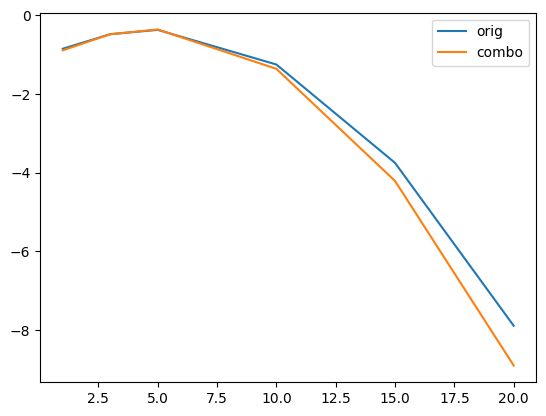

In [16]:
val1 = res_cont_rgb_enc

val2 = res_cont_rgb_notenc + rgb_enc

plt.plot(fps, val1, fps, val2)
plt.legend(['orig', 'combo'])
plt.show()

[-0.13  0.01  0.05  0.05  0.05 -0.15]


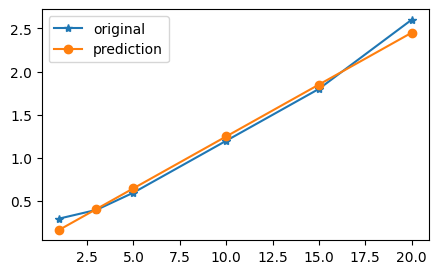

[-0.12  0.03  0.01  0.04  0.09 -0.16]


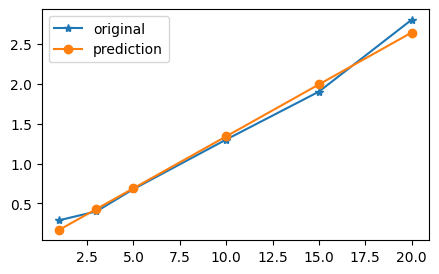

[-0.03  0.17 -0.03]


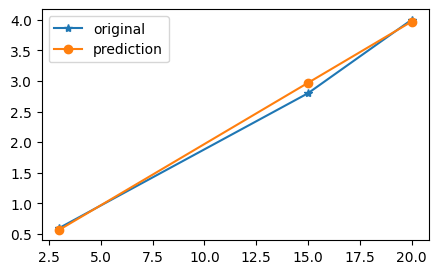

[-0.09  0.1   0.09 -0.06  0.19  0.04]


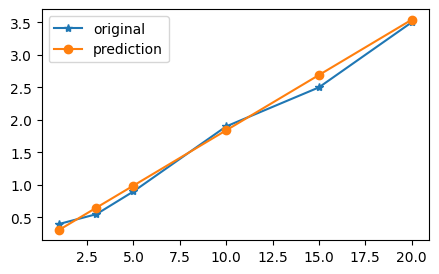

[0.01 0.05]


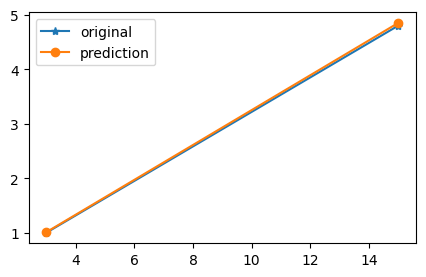

[-0.33 -0.01  0.11  0.36  0.71 -0.44]


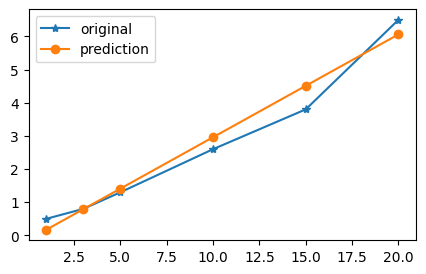

In [8]:
'''
1 node comparison to predicted values
'''

for opt in range(6):
    fig = plt.figure(figsize = (5, 3))
    x = x_axis[opt]

    orig = nodes[opt]
    pred = predict(nodes_pred[opt], x)
    diff = pred - orig
    print(diff)

    plt.plot(x, orig, '*-', x, pred, 'o-')
    plt.legend(['original', 'prediction'])
    plt.show()

In [9]:
'''
get difference between original 2 node values and addition of linefit 1 nodes
'''
x = fps
diffs_rt = []

for opt in range(6):
    opt_1 = mapping[opt][0]
    opt_2 = mapping[opt][1]

    orig = nodes_2[opt]
    val1 = predict(nodes_pred[opt_1], x)
    val2 = predict(nodes_pred[opt_2], x)
    pred = val1 + val2
    diffs_rt.append(pred-orig)

#     fig = plt.figure(figsize = (5, 3))
#     plt.plot(x, orig, '*-', x, pred, 'o-')
#     plt.legend(['original', 'prediction'])
#     plt.show()
print(diffs_rt)

[array([-0.12,  0.01, -0.06, -0.21, -1.06, -1.41]), array([-0.12,  0.03, -0.07, -0.27, -0.52, -3.82]), array([-0.36, -0.55, -0.84, -1.44, -2.74, -5.49]), array([-0.41, -0.58, -0.9 , -1.6 , -2.8 , -8.3 ]), array([-0.22,  0.45,  0.75,  1.6 ,  2.4 ,  2.1 ]), array([-0.45,  0.3 ,  0.66,  1.51,  2.33,  3.01])]


[-0.12  0.03 -0.07 -0.27 -0.52 -3.82]
[-0.02128576  0.28001233 -0.61891526] [-0.36018868  0.02954994  0.24900251  0.05263249 -1.20802533 -3.53297094]


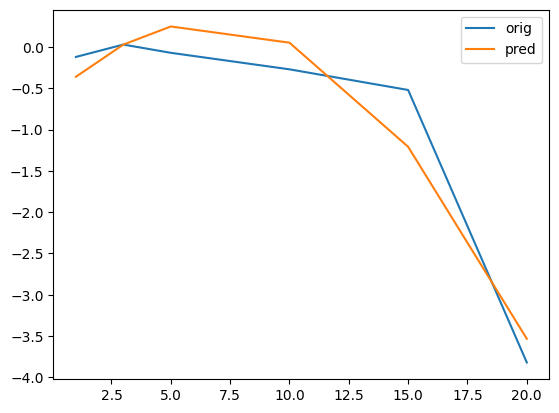

In [10]:
'''
find equations for common mono in lr and depth combos, other smaller accomodation models
'''

val1 = diffs_rt[1]
print(val1)

pol = np.polyfit(fps, val1, 2)
val2 = predict(pol, fps)
print(pol, val2)

plt.plot(fps, val1, fps, val2)
plt.legend(['orig', 'pred'])
plt.show()

In [17]:
'''get difference between original 2 nodes values and line fit model combinations'''
x = fps

new_diff = []
for opt in range(6):
    opt_1 = mapping[opt][0]
    opt_2 = mapping[opt][1]
        
    orig = nodes_2[opt]
    val1 = predict(nodes_pred[opt_1], x)
    val2 = predict(nodes_pred[opt_2], x)
    
    if opt == 1:
        pred = val1 + val2 - rgb_enc
    elif opt == 2:
        pred = val1 + val2 - res_cont_rgb_notenc
    elif opt == 3:
        pred = val1 + val2 - res_cont_rgb_notenc - rgb_enc
    elif opt == 4:
        pred = val1 + val2 - m2
    elif opt == 5:
        pred = val1 + val2 - m2_enc
    else:
        pred = val1 + val2
    diff = pred - orig
    print(diff)
    new_diff.append(diff)
    
#     fig = plt.figure(figsize = (5, 3))
#     plt.plot(x, orig, '*-', x, pred, 'o-')
#     plt.legend(['original', 'prediction'])
#     plt.show()


[-0.12  0.01 -0.06 -0.21 -1.06 -1.41]
[ 0.24  0.   -0.32 -0.32  0.69 -0.29]
[ 0.17 -0.04 -0.23 -0.03  0.26 -0.12]
[ 0.48 -0.1  -0.54 -0.24  1.41  0.6 ]
[ 1.11022302e-16  1.10000000e-01 -9.00000000e-02 -1.40000000e-01
  2.10000000e-01 -8.00000000e-02]
[-0.13  0.14  0.06 -0.07 -0.04  0.03]


[ 0.01420925 -0.0742721 ]


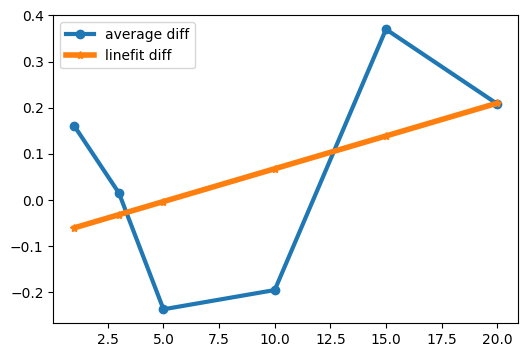

In [12]:
'''
getting line equation for differences between original 2 node values and mathematical combination of 1 nodes
(finding out the baseline)
'''
# diffs_rt =[
#     [ 0.1, -0.1, -0.2, -0.2, -1.3, -1.3],
#     [ 0.09, -0.1,  -0.17, -0.25, -0.8,  -3.7 ],
#     [ 0.1,  -0.55, -1,   -1.85, -3.5,  -4.9 ],
#     [ 0.04, -0.6,  -1.02, -2,  -3.6,  -7.7 ],
    
#     [0.2  0.36 0.55 1.3  1.5  2.5 ],
#     [0.27152682 0.3        0.21806277 0.49225779 1.57       5.25279819]
    
#     [-0.01, -0.02, -0.02, 0.2, -0.22, 0.08],
#     [-0.1, 0.08, 0.07, 0.14, -0.03, 0.12]
# ]

avg = []
for i in range(6):
    # get average of differences across a single fps
    vals = []
    for diff in new_diff:
        vals.append(diff[i])
    # get average of differences across a single fps
    avg.append(np.mean(vals))

coff = get_poly(fps, avg)
pred_avg = predict(coff, fps)
print(coff)

# plot the original average and predicted average
fig = plt.figure(figsize = (6,4))

# for diff in diffs:
#     plt.plot(fps, diff, '*-')
plt.plot(fps, avg, 'o-', linewidth=3)
plt.plot(fps, pred_avg, '*-', linewidth=4)
plt.legend(['average diff', 'linefit diff'])
plt.show()

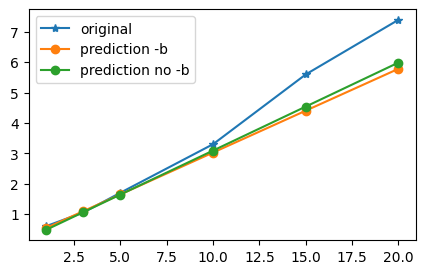

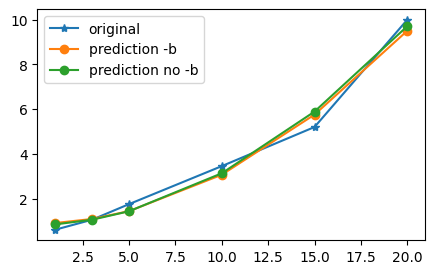

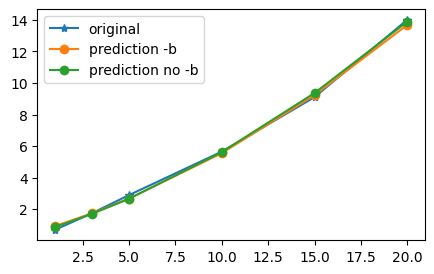

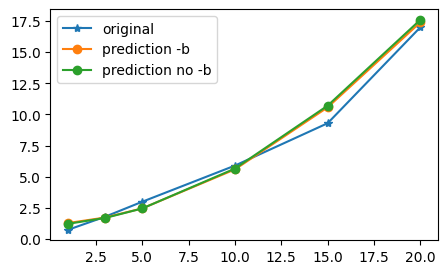

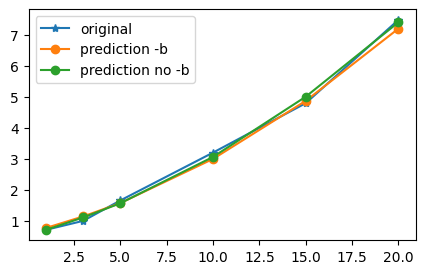

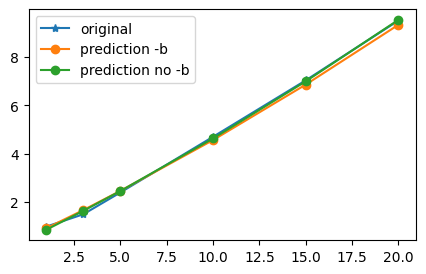

In [18]:
'''
2 nodes comparison to predicted values
'''
x = fps

for opt in range(6):
    fig = plt.figure(figsize = (5, 3))
    opt_1 = mapping[opt][0]
    opt_2 = mapping[opt][1]

    orig = nodes_2[opt]
    val1 = predict(nodes_pred[opt_1], x)
    val2 = predict(nodes_pred[opt_2], x)
    
    if opt == 1:
        pred_wo = val1 + val2 - rgb_enc
        pred_w = val1 + val2 - base - rgb_enc
    elif opt == 2:
        pred_wo = val1 + val2 - res_cont_rgb_notenc
        pred_w = val1 + val2 - base - res_cont_rgb_notenc
    elif opt == 3:
        pred_wo = val1 + val2 - res_cont_rgb_notenc - rgb_enc
        pred_w = val1 + val2 - base - res_cont_rgb_notenc - rgb_enc
    elif opt == 4:
        pred_wo = val1 + val2 - m2
        pred_w = val1 + val2 - base - m2
    elif opt == 5:
        pred_wo = val1 + val2 - m2_enc
        pred_w = val1 + val2 - base - m2_enc
    else:
        pred_wo = val1 + val2
        pred_w = val1 + val2 - base

    plt.plot(x, orig, '*-', x, pred_w, 'o-', x, pred_wo, 'o-')
    plt.legend(['original', 'prediction -b', 'prediction no -b'])
    plt.show()

[ 0.65  0.07 -0.38 -0.68 -0.14  4.74] [ 0.772  0.136 -0.37  -0.81  -0.41   4.33 ]


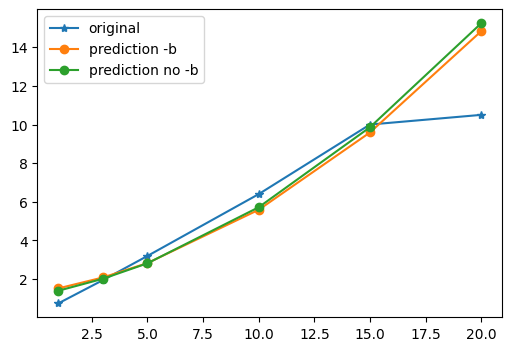

[ 0.96  0.01 -0.69 -0.74  0.71  5.96] [ 1.082  0.076 -0.68  -0.87   0.44   5.55 ]


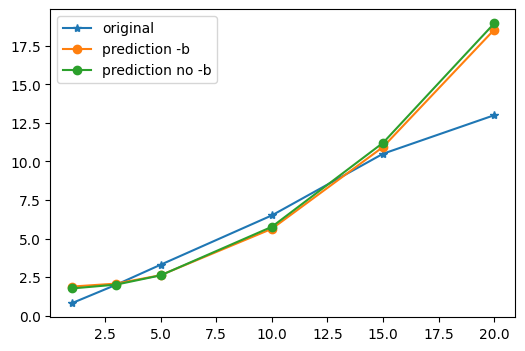

[ 0.27  0.05 -0.59 -0.67  1.39  0.07] [ 0.392  0.116 -0.58  -0.8    1.12  -0.34 ]


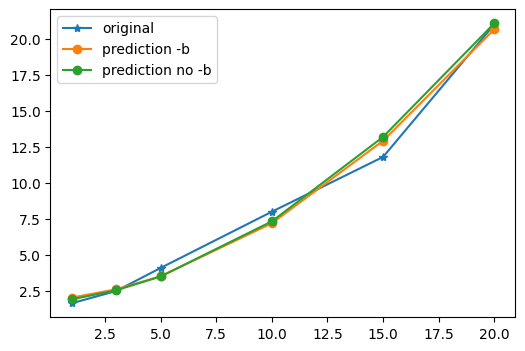

In [19]:
'''
3 nodes comparison to predicted values
'''
x = fps

for opt in range(3):
    fig = plt.figure(figsize = (6, 4))
    opt_1 = mapping_3[opt][0]
    opt_2 = mapping_3[opt][1]
    opt_3 = mapping_3[opt][2]


    orig = nodes_3[opt]
    val1 = predict(nodes_pred[opt_1], x)
    val2 = predict(nodes_pred[opt_2], x)
    
    if opt == 0:
        val2 = val2 - m2 - res_cont_rgb_notenc
    elif opt == 1:
        val2 = val2 - m2 - res_cont_rgb_notenc - rgb_enc
    elif opt == 2:
        val2 = val2 - m2_enc - res_cont_rgb_notenc - rgb_enc

    val3 = predict(nodes_pred[opt_3], x)
    pred_wo = val1 + val2 + val3
    pred_w = val1 + (val2 - base) + (val3 - base)
    diff1 = pred_wo - orig
    diff2 = pred_w - orig
    print(diff1, diff2)

    plt.plot(x, orig, '*-', x, pred_w, 'o-', x, pred_wo, 'o-')
    plt.legend(['original', 'prediction -b', 'prediction no -b'])
    plt.show()

# when baseline is deducted, predicted values tend to fall below original more often (Fav:4, Neu:0,2, Det:1,3,5)

In [15]:
# without deduction, with deduction
